In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

In [2]:
df = pd.read_csv("passengers2.csv")
df["Month"] = pd.to_datetime(df["Month"])
df = df.sort_values("Month").reset_index(drop=True)

# удобный индекс по времени
df = df.set_index("Month")

print(df.head(3))
print("\nЧисло пропусков в target:", df["target"].isna().sum())

            reference  target  missing
Month                                 
1949-01-01        112   112.0      NaN
1949-02-01        118   118.0      NaN
1949-03-01        132   132.0      NaN

Число пропусков в target: 28


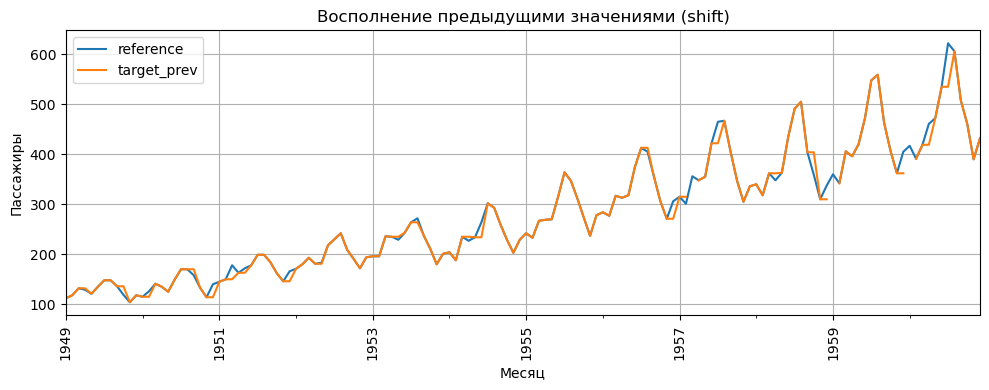

In [3]:

prev1 = df["target"].shift(1)
target_prev_shift = df["target"].where(~df["target"].isna(), prev1)
df["target_prev"] = target_prev_shift

ax = df[["reference", "target_prev"]].plot(title="Восполнение предыдущими значениями (shift)")
ax.set_xlabel("Месяц")
ax.set_ylabel("Пассажиры")
plt.xticks(rotation=90, ha="center")
plt.tight_layout(); plt.show()

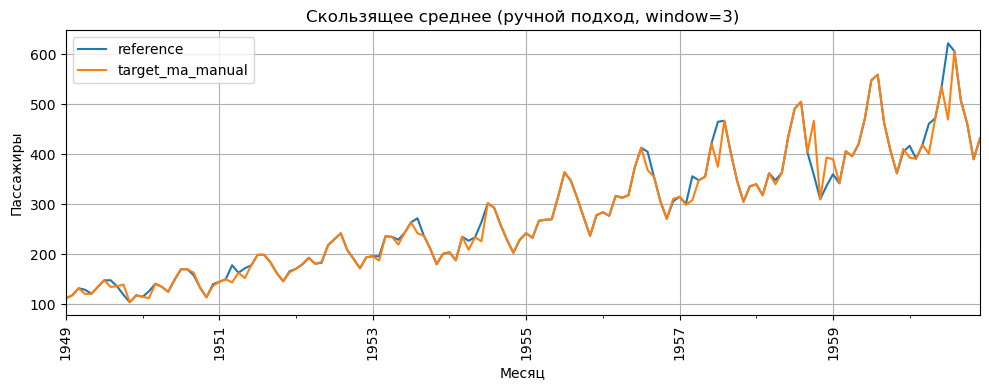

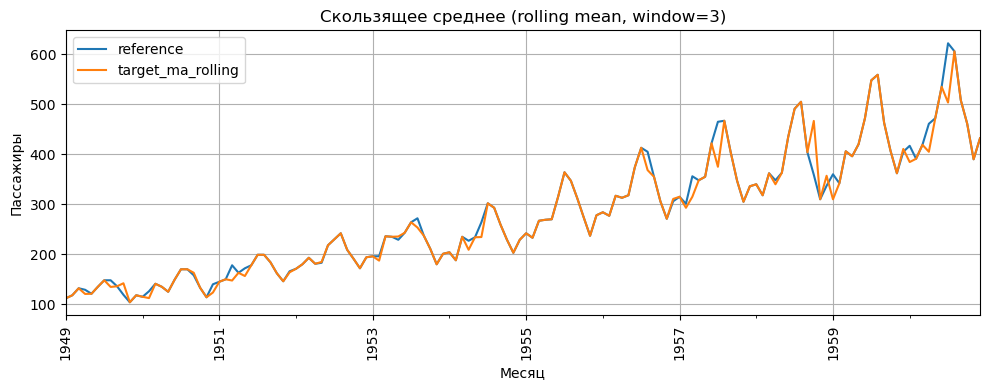

In [4]:
target_ma_manual = df["target"].copy()

for i in range(len(target_ma_manual)):
    if pd.isna(target_ma_manual.iloc[i]):
        left = target_ma_manual.iloc[max(0, i-3):i]
        target_ma_manual.iloc[i] = left.mean()

ma_prev3 = df["target"].rolling(window=3, min_periods=1).mean().shift(1)
target_ma_rolling = df["target"].where(~df["target"].isna(), ma_prev3)

df["target_ma_manual"]  = target_ma_manual
df["target_ma_rolling"] = target_ma_rolling

ax = df[["reference", "target_ma_manual"]].plot(title="Скользящее среднее (ручной подход, window=3)")
ax.set_xlabel("Месяц"); ax.set_ylabel("Пассажиры")
plt.xticks(rotation=90, ha="center"); plt.tight_layout(); plt.show()

ax = df[["reference", "target_ma_rolling"]].plot(title="Скользящее среднее (rolling mean, window=3)")
ax.set_xlabel("Месяц"); ax.set_ylabel("Пассажиры")
plt.xticks(rotation=90, ha="center"); plt.tight_layout(); plt.show()

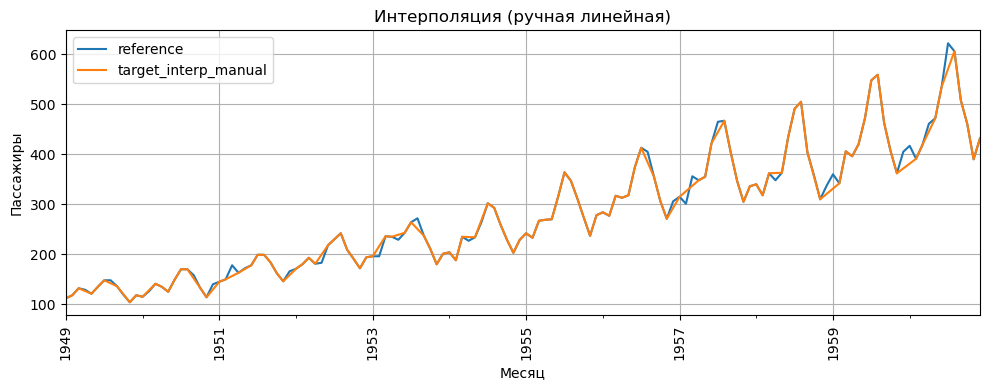

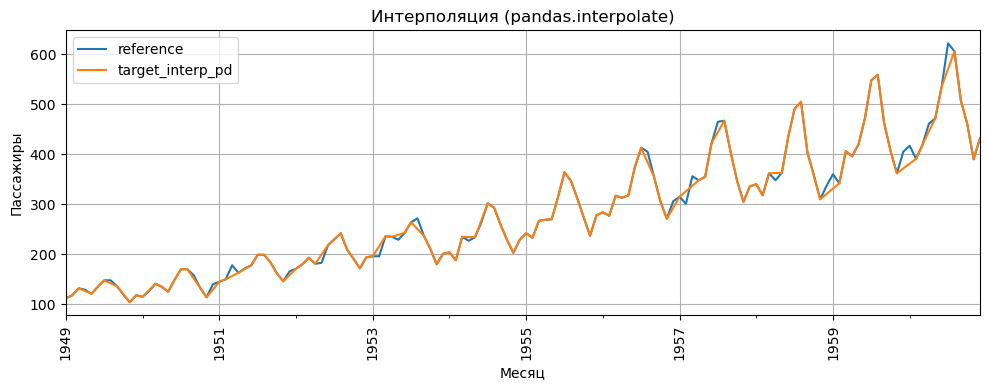

In [5]:
x = np.arange(len(df))
y = df["target"].to_numpy(dtype=float)
y_lin = y.copy()

i = 0
while i < len(y_lin):
    if np.isnan(y_lin[i]):
        start = i-1
        j = i
        while j < len(y_lin) and np.isnan(y_lin[j]):
            j += 1
        end = j
        y0 = y_lin[start] if start >= 0 else np.nan
        y1 = y_lin[end]   if end < len(y_lin) else np.nan

        if not np.isnan(y0) and not np.isnan(y1):
            gap = end - start
            x0, x1 = start, end
            for k in range(1, gap):
                x = start + k
                y_lin[x] = (y0 * (x1 - x) + y1 * (x - x0)) / (x1 - x0)

        i = end
    else:
        i += 1

target_interp = pd.Series(y, index=df.index).interpolate(method="linear")

df["target_interp_manual"] = y_lin
df["target_interp_pd"]     = target_interp

ax = df[["reference", "target_interp_manual"]].plot(title="Интерполяция (ручная линейная)")
ax.set_xlabel("Месяц"); ax.set_ylabel("Пассажиры")
plt.xticks(rotation=90, ha="center"); plt.tight_layout(); plt.show()

ax = df[["reference", "target_interp_pd"]].plot(title="Интерполяция (pandas.interpolate)")
ax.set_xlabel("Месяц"); ax.set_ylabel("Пассажиры")
plt.xticks(rotation=90, ha="center"); plt.tight_layout(); plt.show()

In [6]:
def mae(a, b):
    m = ~np.isnan(a) & ~np.isnan(b)
    return np.mean(np.abs(a[m] - b[m]))

print("MAE(prev fill)      :", mae(df["reference"].to_numpy(), df["target_prev"].to_numpy()))
print("MAE(MA manual)      :", mae(df["reference"].to_numpy(), df["target_ma_manual"].to_numpy()))
print("MAE(MA rolling)     :", mae(df["reference"].to_numpy(), df["target_ma_rolling"].to_numpy()))
print("MAE(interp manual)  :", mae(df["reference"].to_numpy(), df["target_interp_manual"].to_numpy()))
print("MAE(interp pandas)  :", mae(df["reference"].to_numpy(), df["target_interp_pd"].to_numpy()))

MAE(prev fill)      : 3.8156028368794326
MAE(MA manual)      : 5.912122770919067
MAE(MA rolling)     : 5.481481481481482
MAE(interp manual)  : 3.017361111111111
MAE(interp pandas)  : 3.017361111111111


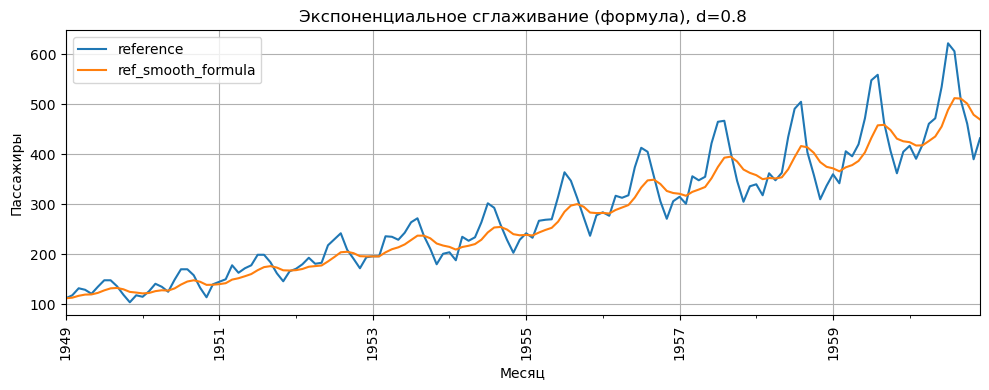

In [7]:
d = 0.8
ref = df["reference"].astype(float).to_numpy()

S = np.empty_like(ref)
S[:] = np.nan
S[0] = ref[0]

for t in range(1, len(ref)):
    S[t] = d * S[t-1] + (1 - d) * ref[t]

df["ref_smooth_formula"] = S

ax = df[["reference", "ref_smooth_formula"]].plot(title=f"Экспоненциальное сглаживание (формула), d={d}")
ax.set_xlabel("Месяц"); ax.set_ylabel("Пассажиры")
plt.xticks(rotation=90, ha="center"); plt.tight_layout(); plt.show()

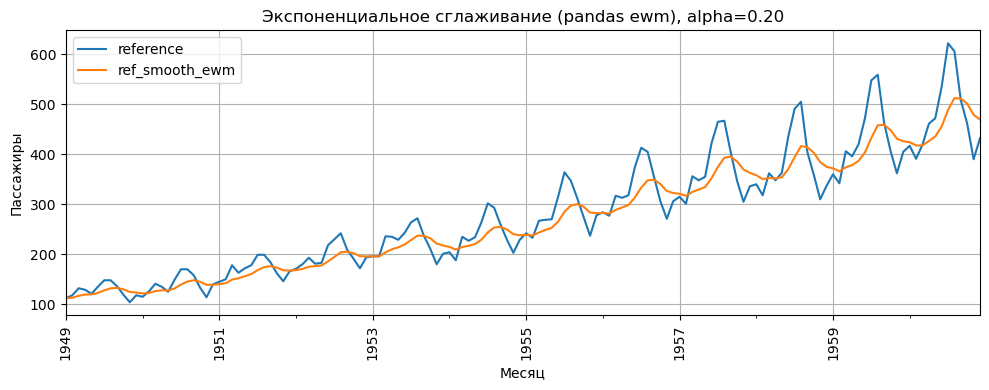

In [8]:
alpha = 1 - d
df["ref_smooth_ewm"] = df["reference"].ewm(alpha=alpha, adjust=False).mean()

ax = df[["reference", "ref_smooth_ewm"]].plot(title=f"Экспоненциальное сглаживание (pandas ewm), alpha={alpha:.2f}")
ax.set_xlabel("Месяц"); ax.set_ylabel("Пассажиры")
plt.xticks(rotation=90, ha="center"); plt.tight_layout(); plt.show()

In [9]:
out_path = "passengers2_filled_smoothed.csv"
df.to_csv(out_path)
print("Сохранено:", out_path)

Сохранено: passengers2_filled_smoothed.csv
